In [1]:
# standard lib imports
import sys
import warnings
from collections import Counter
from collections import defaultdict

# 3rd party imports
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn impots 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
                             average_precision_score,
                             roc_auc_score)

from scipy.stats import sem

# external packages in local directory
sys.path.append("../simulate-groups")
from simulate_groups import simulate_ll

# removing warning message 
warnings.filterwarnings("ignore")

In [2]:
sample_sizes = [10, 50, 100, 250, 500, 750, 1000, 3500, 5000, 10000]
l1_ratios = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
random_state_vals =  [i for i in range(0,42,2)] # 20 random shuffling values

results = []
for idx, sample_size in enumerate(sample_sizes):
	X, y, info_dict = simulate_ll(n=sample_size, p=20, uncorr_frac=0.1, num_groups=5)
	for random_state_val in random_state_vals:

		model_name = "Model_{}_n{}".format(idx, sample_size)

		# splitting and trianing data
		X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state_val)
		model_cv = LogisticRegressionCV(cv=3, penalty="elasticnet", solver="saga", l1_ratios=l1_ratios).fit(X_train, y_train)

		# testing model and extracting results
		y_pred = model_cv.predict(X_test)
		aupr_score = round(average_precision_score(y_test, y_pred), 3)
		try:
			auroc_score = round(roc_auc_score(y_test, y_pred), 3)
		except ValueError:
			auroc_score = 0
		mean_cs_score = np.round(np.mean(model_cv.Cs_), 3)
		best_l1 = model_cv.l1_ratio_

		# recording data
		result = [model_name, random_state_val, sample_size, best_l1[0], aupr_score, auroc_score, mean_cs_score]
		results.append(result)



In [3]:
# creating pandas dataframe that contains all the results from
col_names = ["name", "rand_seed", "sample_size", "best_l1", "AUPR", "AUROC", "avg_cs_score"]
model_df = pd.DataFrame(results, columns=col_names).fillna(0)

In [4]:
collected_data = []
for df_name, df in model_df.groupby("name"):
    mean_aupr = np.round(np.mean(df["AUPR"].values),3)
    apur_sem = np.round(sem(df["AUPR"]), 3)
    mean_auroc = np.round(np.mean(df["AUROC"].values), 3)
    auroc_sem = np.round(sem(df["AUROC"]), 3)
    result = [df_name, mean_aupr, apur_sem, mean_auroc, auroc_sem]
    collected_data.append(result)

cols = ["name", "aupr_score", "aupr_sem", "auroc_score", "auroc_sem"]
results_df = pd.DataFrame(collected_data, columns=cols)

In [5]:
results_df

,name,aupr_score,aupr_sem,auroc_score,auroc_sem
0,Model_0_n10,0.429,0.071,0.333,0.063
1,Model_1_n50,0.243,0.027,0.488,0.012
2,Model_2_n100,0.876,0.018,0.846,0.025
3,Model_3_n250,0.894,0.009,0.913,0.006
4,Model_4_n500,0.665,0.008,0.506,0.004
5,Model_5_n750,0.811,0.008,0.899,0.005
6,Model_6_n1000,0.824,0.008,0.819,0.006
7,Model_7_n3500,0.847,0.003,0.859,0.002
8,Model_8_n5000,0.572,0.005,0.744,0.003
9,Model_9_n10000,0.866,0.002,0.911,0.001


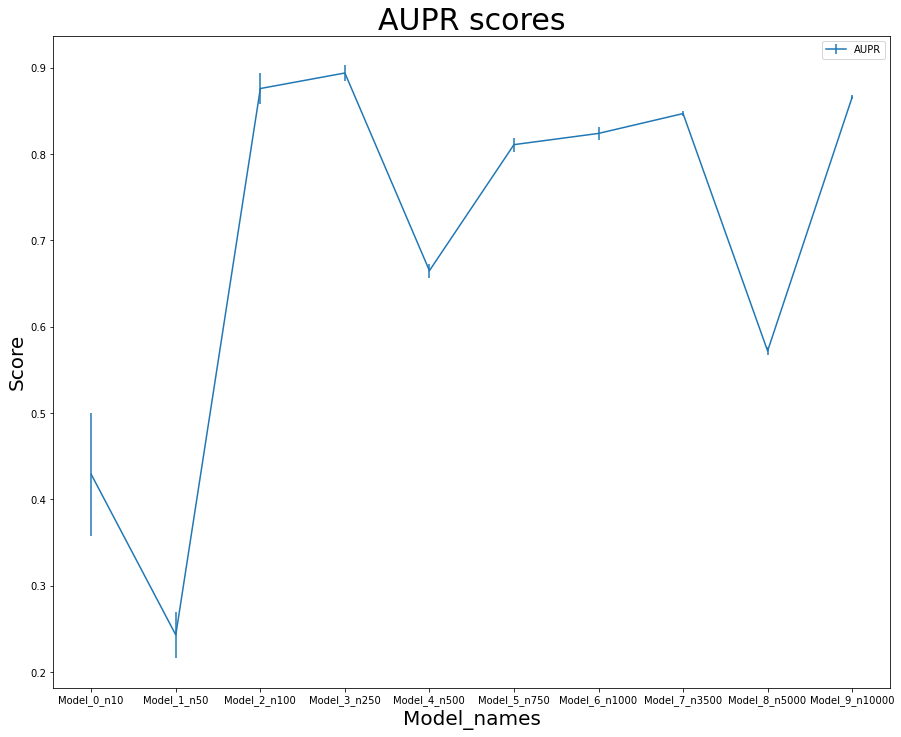

In [6]:
# only AUPR
plt.figure(figsize=(15,12))
ax = plt.subplot()
ax.errorbar(results_df["name"], results_df["aupr_score"], yerr=results_df["aupr_sem"], label="AUPR")
ax.set_title("AUPR scores", fontsize=30)
ax.set_ylabel("Score", fontsize=20)
ax.set_xlabel("Model_names", fontsize=20)
ax.legend()

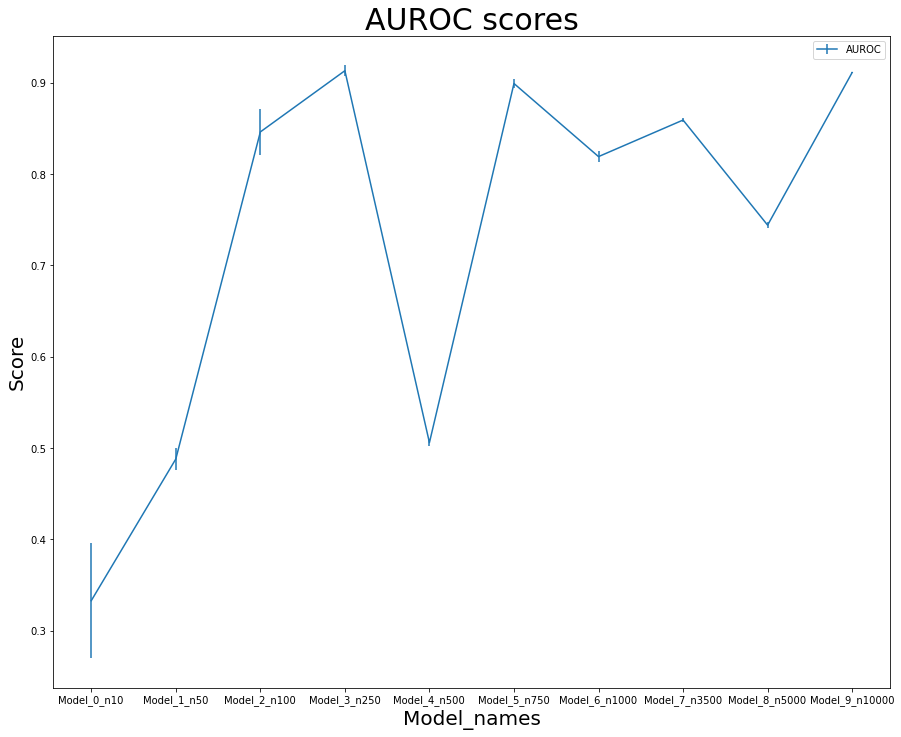

In [7]:
plt.figure(figsize=(15,12))
ax = plt.subplot()
ax.errorbar(results_df["name"], results_df["auroc_score"], yerr=results_df["auroc_sem"], label="AUROC")
ax.set_title("AUROC scores", fontsize=30)
ax.set_ylabel("Score", fontsize=20)
ax.set_xlabel("Model_names", fontsize=20)
ax.legend()

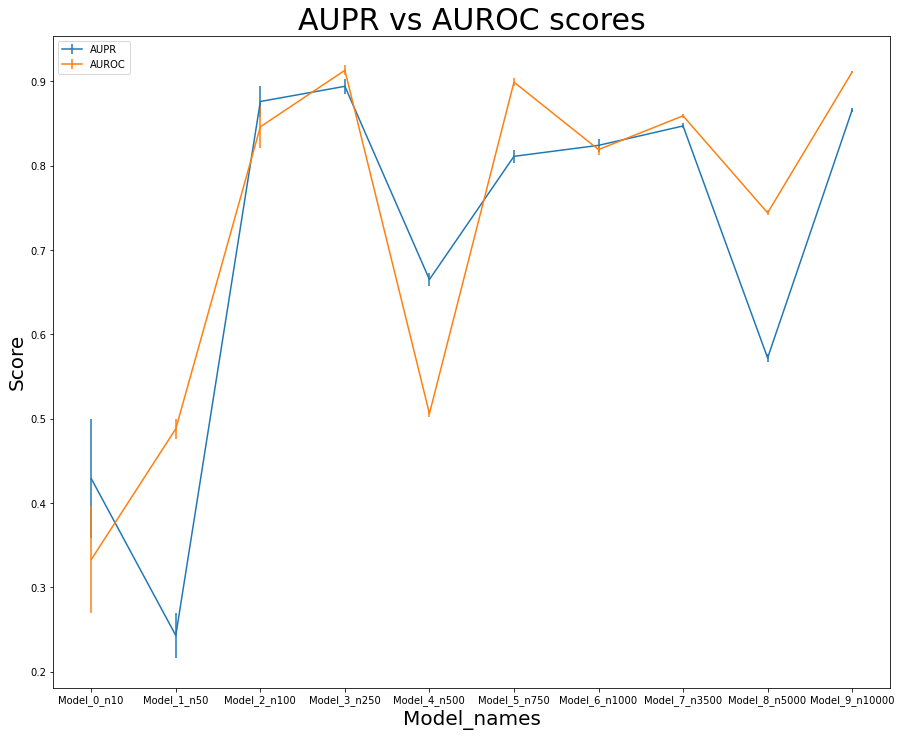

In [8]:
# mereged
plt.figure(figsize=(15,12))
ax = plt.subplot()
ax.errorbar(results_df["name"], results_df["aupr_score"], yerr=results_df["aupr_sem"], label="AUPR")
ax.errorbar(results_df["name"], results_df["auroc_score"], yerr=results_df["auroc_sem"], label="AUROC")
ax.set_title("AUPR vs AUROC scores", fontsize=30)
ax.set_ylabel("Score", fontsize=20)
ax.set_xlabel("Model_names", fontsize=20)
ax.legend()